In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import missingno as msno
import seaborn as sns
%matplotlib inline
import math
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import plotly
plotly.tools.set_credentials_file(username='bmoore49', api_key='xnI7D5RMqkWnQzD76tDx')
import plotly.plotly as py

pd.set_option('display.max_columns', None)

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

## Import Data

This dataset can be found on this page:<br>
https://www.kaggle.com/c/zillow-prize-1/data

In [2]:
# Put in file locations and names
data_folder = '/Users/bryan/Movies/Zestimate-Dataset'
properties_file = 'properties_2017.csv'
train_data_file_2017='train_2017.csv'

# Load in data as pandas file
properties = pd.read_csv(data_folder + '/' + properties_file)
train_df = pd.read_csv(data_folder+'/'+train_data_file_2017, parse_dates=["transactiondate"])
merged_df = pd.merge(train_df,properties)

# Shuffle rows
merged_df = merged_df.sample(frac=1)

df_orig = merged_df # Make copy for later

print('The are %i features in this dataset' %len(merged_df.columns))

# Make sure no rows corresponding to missing entries for target (logerror)
# merged_df=merged_df[~merged_df['logerror'].isnull()]
# missingdata_df=merged_df.dropna()
# missingdata_df.shape
missingdata_df = merged_df.columns[merged_df.isnull().any()].tolist()
merged_df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
25914,14617039,0.000414,2017-04-13,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,NaN,NaN,1181.0,1181.0,NaN,NaN,NaN,NaN,6059.0,NaN,1.0,2.0,0.0,NaN,NaN,33897953.0,-117967921.0,NaN,NaN,NaN,NaN,NaN,NaN,34,266.0,NaN,6.059002e+07,24812.0,1286.0,NaN,97041.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1980.0,NaN,NaN,78586.0,416150.0,2016.0,337564.0,4850.38,NaN,NaN,6.059002e+13
68277,11348698,0.046026,2017-08-18,1.0,NaN,NaN,4.0,4.0,NaN,9.0,4.0,NaN,NaN,3568.0,3568.0,NaN,NaN,NaN,NaN,6037.0,NaN,4.0,NaN,NaN,NaN,2.0,34468082.0,-118563257.0,7018.0,1.0,NaN,NaN,NaN,1.0,0100,261.0,LCA25*,6.037920e+07,NaN,3101.0,NaN,96377.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,2004.0,NaN,NaN,452000.0,752000.0,2016.0,300000.0,12932.86,NaN,NaN,6.037920e+13
59384,12247434,0.001074,2017-07-21,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33862237.0,-118300214.0,8665.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LAR1,6.037291e+07,12447.0,3101.0,273930.0,96105.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1956.0,NaN,NaN,86466.0,432334.0,2016.0,345868.0,5459.82,NaN,NaN,6.037291e+13
37131,14403133,-0.058124,2017-05-17,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,NaN,1016.0,1016.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,1.0,180.0,NaN,NaN,33532490.0,-117771761.0,3650.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,52842.0,1286.0,NaN,96969.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,1934.0,2.0,NaN,22170.0,82166.0,2016.0,59996.0,1589.68,NaN,NaN,6.059063e+13
38864,12762234,-0.002251,2017-05-23,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,NaN,1080.0,1080.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33892201.0,-118012284.0,5933.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LMR1*,6.037504e+07,5465.0,3101.0,NaN,96190.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1957.0,NaN,NaN,99802.0,438371.0,2016.0,338569.0,5519.00,NaN,NaN,6.037504e+13


In [3]:
#msno.matrix(merged_df[missingdata_df])
#msno.bar(merged_df[missingdata_df], color="blue", log=True, figsize=(30,18))
# msno.heatmap(merged_df[missingdata_df],figsize=(40,30))

In [4]:
# Holds boolean whether entry is null or not
def nan_investigation(df):
    num_entries = df.shape[0]
    df_titles = list(df.columns.values)
    nan_count_df = pd.DataFrame(columns=df_titles,index=['Tot_Null','Tot_Not_Null','Perc_Null'])
    for column in df:
        nan_sum = df[column].isnull().sum()
        nan_count_df.set_value('Tot_Null', column, nan_sum)
        nan_count_df.set_value('Tot_Not_Null', column, num_entries-nan_sum)
        nan_count_df.set_value('Perc_Null', column, nan_sum/num_entries)

    display(nan_count_df)

In [5]:
# Split date column into year, month, day to investigate relationships independently

merged_df['transactiondate'] = pd.to_datetime(merged_df['transactiondate'])
merged_df['Year'] = merged_df['transactiondate'].dt.year
merged_df['Month']=merged_df['transactiondate'].dt.month
merged_df['Day']=merged_df['transactiondate'].dt.day
merged_df=merged_df.drop(['transactiondate'],axis=1)

In [6]:
nan_investigation(merged_df)

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,Year,Month,Day
Tot_Null,0,0,52606,77406,77563,34,34,77598,27804,650,76999,71576,235,3690,77571,74586,71576,77227,34,69324,650,52093,52093,76074,28042,34,34,8292,61439,76744,77148,76539,62534,34,34,27137,34,1506,34,46639,84,34,77563,67507,77390,26910,75220,77543,304,60014,77441,149,35,34,36,39,74713,74713,281,0,0,0
Tot_Not_Null,77613,77613,25007,207,50,77579,77579,15,49809,76963,614,6037,77378,73923,42,3027,6037,386,77579,8289,76963,25520,25520,1539,49571,77579,77579,69321,16174,869,465,1074,15079,77579,77579,50476,77579,76107,77579,30974,77529,77579,50,10106,223,50703,2393,70,77309,17599,172,77464,77578,77579,77577,77574,2900,2900,77332,77613,77613,77613
Perc_Null,0,0,0.677799,0.997333,0.999356,0.000438071,0.000438071,0.999807,0.358239,0.00837489,0.992089,0.922217,0.00302784,0.0475436,0.999459,0.960999,0.922217,0.995027,0.000438071,0.893201,0.00837489,0.671189,0.671189,0.980171,0.361305,0.000438071,0.000438071,0.106838,0.791607,0.988803,0.994009,0.986162,0.805716,0.000438071,0.000438071,0.349645,0.000438071,0.019404,0.000438071,0.600917,0.00108229,0.000438071,0.999356,0.86979,0.997127,0.34672,0.969168,0.999098,0.00391687,0.773247,0.997784,0.00191978,0.000450955,0.000438071,0.00046384,0.000502493,0.962635,0.962635,0.00362053,0,0,0


In [7]:
# We now drop any feature missing more than 80% of data
merged_df=merged_df.drop(columns=['architecturalstyletypeid','basementsqft','buildingclasstypeid',
                                  'decktypeid','finishedfloor1squarefeet','finishedsquarefeet13',
                                  'finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6',
                                  'fireplacecnt','hashottuborspa','poolsizesum','pooltypeid10','pooltypeid2',
                                  'pooltypeid7','storytypeid','threequarterbathnbr','typeconstructiontypeid',
                                  'yardbuildingsqft17','yardbuildingsqft26','fireplaceflag',
                                  'taxdelinquencyflag','taxdelinquencyyear'])

# We also remove parcelid as this is unique to each row, and thus not useful
merged_df=merged_df.drop(columns='parcelid')
merged_df.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,Year,Month,Day
25914,0.000414,NaN,1.5,3.0,NaN,1.5,1181.0,1181.0,6059.0,1.0,2.0,0.0,NaN,33897953.0,-117967921.0,NaN,NaN,34,266.0,NaN,6.059002e+07,24812.0,1286.0,NaN,97041.0,0.0,NaN,1980.0,NaN,78586.0,416150.0,2016.0,337564.0,4850.38,6.059002e+13,2017,4,13
68277,0.046026,1.0,4.0,4.0,9.0,4.0,3568.0,3568.0,6037.0,4.0,NaN,NaN,2.0,34468082.0,-118563257.0,7018.0,1.0,0100,261.0,LCA25*,6.037920e+07,NaN,3101.0,NaN,96377.0,0.0,1.0,2004.0,NaN,452000.0,752000.0,2016.0,300000.0,12932.86,6.037920e+13,2017,8,18
59384,0.001074,NaN,2.0,2.0,6.0,2.0,1243.0,1243.0,6037.0,2.0,NaN,NaN,2.0,33862237.0,-118300214.0,8665.0,NaN,0100,261.0,LAR1,6.037291e+07,12447.0,3101.0,273930.0,96105.0,0.0,1.0,1956.0,NaN,86466.0,432334.0,2016.0,345868.0,5459.82,6.037291e+13,2017,7,21
37131,-0.058124,NaN,2.0,4.0,NaN,2.0,1016.0,1016.0,6059.0,2.0,1.0,180.0,NaN,33532490.0,-117771761.0,3650.0,NaN,122,261.0,NaN,6.059063e+07,52842.0,1286.0,NaN,96969.0,7.0,NaN,1934.0,2.0,22170.0,82166.0,2016.0,59996.0,1589.68,6.059063e+13,2017,5,17
38864,-0.002251,NaN,2.0,3.0,6.0,2.0,1080.0,1080.0,6037.0,2.0,NaN,NaN,2.0,33892201.0,-118012284.0,5933.0,NaN,0100,261.0,LMR1*,6.037504e+07,5465.0,3101.0,NaN,96190.0,0.0,1.0,1957.0,NaN,99802.0,438371.0,2016.0,338569.0,5519.00,6.037504e+13,2017,5,23


In [8]:
# Make a copy of this cleaned dataframe for later use
cleaned_df = merged_df

In [9]:
# Now check correlations of all of these with the target (taxvaluedollarcnt)
# This is the total tax assessed value of the parcel
merged_df.corr()['taxvaluedollarcnt'].abs().sort_values(ascending=False)

taxvaluedollarcnt               1.000000
taxamount                       0.990001
landtaxvaluedollarcnt           0.957909
structuretaxvaluedollarcnt      0.796731
finishedsquarefeet12            0.606334
calculatedfinishedsquarefeet    0.583155
calculatedbathnbr               0.484819
fullbathcnt                     0.472832
bathroomcnt                     0.461013
garagetotalsqft                 0.345202
garagecarcnt                    0.328466
buildingqualitytypeid           0.327590
bedroomcnt                      0.239326
numberofstories                 0.136264
yearbuilt                       0.119309
heatingorsystemtypeid           0.110031
latitude                        0.098225
regionidcounty                  0.039267
propertylandusetypeid           0.035930
longitude                       0.032118
regionidcity                    0.024089
lotsizesquarefeet               0.022497
regionidneighborhood            0.022010
regionidzip                     0.014548
airconditioningt

In [10]:
# Keep the top 20 features which correlate the highest with the target
top_correlated=merged_df.corr()['taxvaluedollarcnt'].abs().sort_values(ascending=False).nlargest(20)
print(top_correlated)

taxvaluedollarcnt               1.000000
taxamount                       0.990001
landtaxvaluedollarcnt           0.957909
structuretaxvaluedollarcnt      0.796731
finishedsquarefeet12            0.606334
calculatedfinishedsquarefeet    0.583155
calculatedbathnbr               0.484819
fullbathcnt                     0.472832
bathroomcnt                     0.461013
garagetotalsqft                 0.345202
garagecarcnt                    0.328466
buildingqualitytypeid           0.327590
bedroomcnt                      0.239326
numberofstories                 0.136264
yearbuilt                       0.119309
heatingorsystemtypeid           0.110031
latitude                        0.098225
regionidcounty                  0.039267
propertylandusetypeid           0.035930
longitude                       0.032118
Name: taxvaluedollarcnt, dtype: float64


From above we see that we would really like to keep taxamount, landtaxvaluedollarcnt, structuretaxvaluedollarcnt, finishedsquarefeet12, and calculatedfinishedsquarefeet as they all correlate with our target with more than 0.5.

In [11]:
# drop rows with nan in target column in combined dataframe 

df_target = merged_df['taxvaluedollarcnt']

df_new=merged_df[list(top_correlated[:10].index)]
df_new = df_new.drop(columns=['taxvaluedollarcnt']) # drop from feature matrix

df_new.head()

,taxamount,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,calculatedfinishedsquarefeet,calculatedbathnbr,fullbathcnt,bathroomcnt,garagetotalsqft
25914,4850.38,337564.0,78586.0,1181.0,1181.0,1.5,1.0,1.5,0.0
68277,12932.86,300000.0,452000.0,3568.0,3568.0,4.0,4.0,4.0,NaN
59384,5459.82,345868.0,86466.0,1243.0,1243.0,2.0,2.0,2.0,NaN
37131,1589.68,59996.0,22170.0,1016.0,1016.0,2.0,2.0,2.0,180.0
38864,5519.00,338569.0,99802.0,1080.0,1080.0,2.0,2.0,2.0,NaN


Now investigate relationship between these remaining features

In [12]:
df_new.corr()

,taxamount,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,calculatedfinishedsquarefeet,calculatedbathnbr,fullbathcnt,bathroomcnt,garagetotalsqft
taxamount,1.000000,0.944211,0.798992,0.608228,0.587078,0.490269,0.481077,0.465966,0.334874
landtaxvaluedollarcnt,0.944211,1.000000,0.590331,0.469534,0.449920,0.365242,0.356347,0.347442,0.257996
structuretaxvaluedollarcnt,0.798992,0.590331,1.000000,0.720019,0.696255,0.604757,0.589588,0.566023,0.412085
finishedsquarefeet12,0.608228,0.469534,0.720019,1.000000,1.000000,0.809971,0.788357,0.803920,0.618204
calculatedfinishedsquarefeet,0.587078,0.449920,0.696255,1.000000,1.000000,0.807093,0.786693,0.772863,0.599186
calculatedbathnbr,0.490269,0.365242,0.604757,0.809971,0.807093,1.000000,0.984499,1.000000,0.442955
fullbathcnt,0.481077,0.356347,0.589588,0.788357,0.786693,0.984499,1.000000,0.984499,0.461738
bathroomcnt,0.465966,0.347442,0.566023,0.803920,0.772863,1.000000,0.984499,1.000000,0.451538
garagetotalsqft,0.334874,0.257996,0.412085,0.618204,0.599186,0.442955,0.461738,0.451538,1.000000


taxamount and labdtaxvaluedollarcnt strongly covary, but we will keep landtaxvaluedollarcnt as it correlates less strongly with many other features.<br>
calculatedfinishedsquarefeet and finishedsquarefeet12 correlate with score of 1.00. We will remove calculatedfinishedsquarefeet<br>
calculatedbathnbr correlates strongly with many other features and so will be removed.<br>
fullbathcnt correlates strongly with bathroomcnt. We will remove bathroomcnt.<br>

## Complete Features For Our Model

In [13]:
df_model = df_new.drop(columns=['taxamount','calculatedfinishedsquarefeet','calculatedbathnbr',
                                'bathroomcnt'],axis=1)
df_model.corr()

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,garagetotalsqft
landtaxvaluedollarcnt,1.000000,0.590331,0.469534,0.356347,0.257996
structuretaxvaluedollarcnt,0.590331,1.000000,0.720019,0.589588,0.412085
finishedsquarefeet12,0.469534,0.720019,1.000000,0.788357,0.618204
fullbathcnt,0.356347,0.589588,0.788357,1.000000,0.461738
garagetotalsqft,0.257996,0.412085,0.618204,0.461738,1.000000


In [14]:
# Definition to calculate correlation coefficient, which will be used below for inclusion in the seaborn plots
def corrfunc(x, y, **kws):
    r,_ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .6), xycoords=ax.transAxes, size = 24)
# This is a definition to create the pairwise seaborn plots
def create_pairwise_plots(df):
    cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)
    sns.set_context(font_scale=2)
    g = sns.PairGrid(df) # Set up pair grid
    g.map_upper(plt.scatter, s=10, color = 'red') # Set up scatter plot on the upper triangle
#     g.map_diag(sns.distplot, kde=False, color = 'red') # Set up distribution on the diagonal
#     g.map_lower(sns.kdeplot, cmap = cmap) # Include density Plot on the lower triangle
#     g.map_lower(corrfunc); # Add correlation coefficients to density plots on the lower triangle

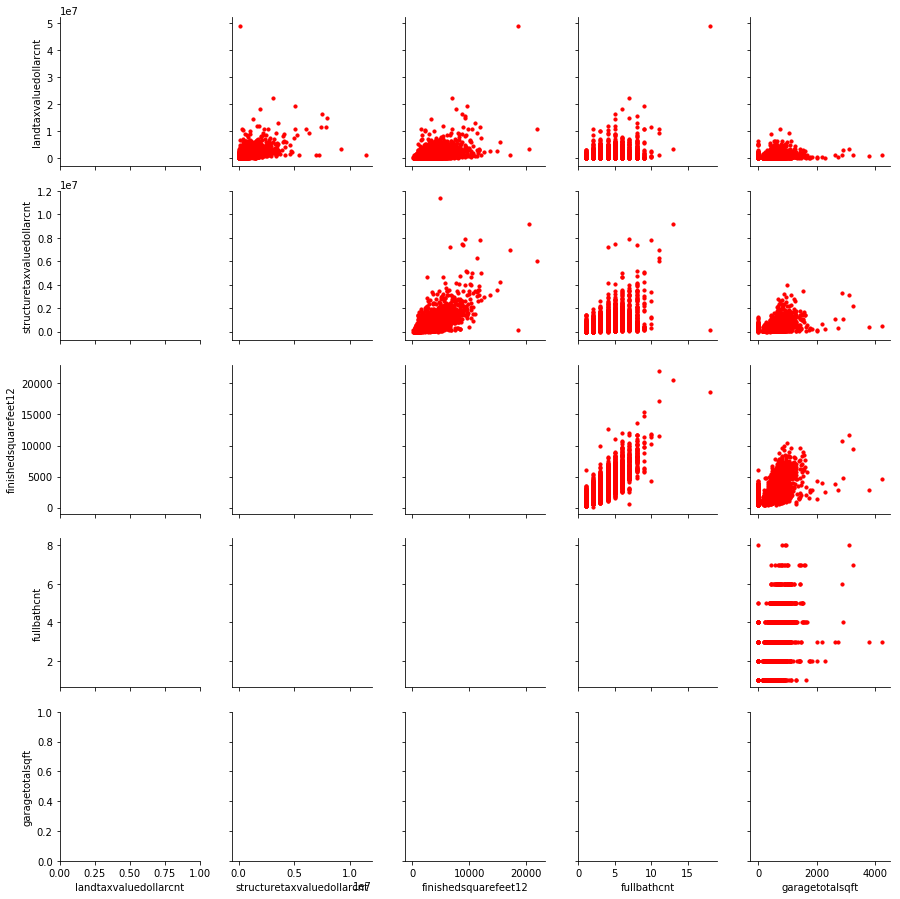

In [15]:
create_pairwise_plots(df_model)

From the above plot it does not appear that there are any severe covariances remaining.

In [16]:
nan_investigation(df_model)

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,garagetotalsqft
Tot_Null,36,149,3690,650,52093
Tot_Not_Null,77577,77464,73923,76963,25520
Perc_Null,0.00046384,0.00191978,0.0475436,0.00837489,0.671189


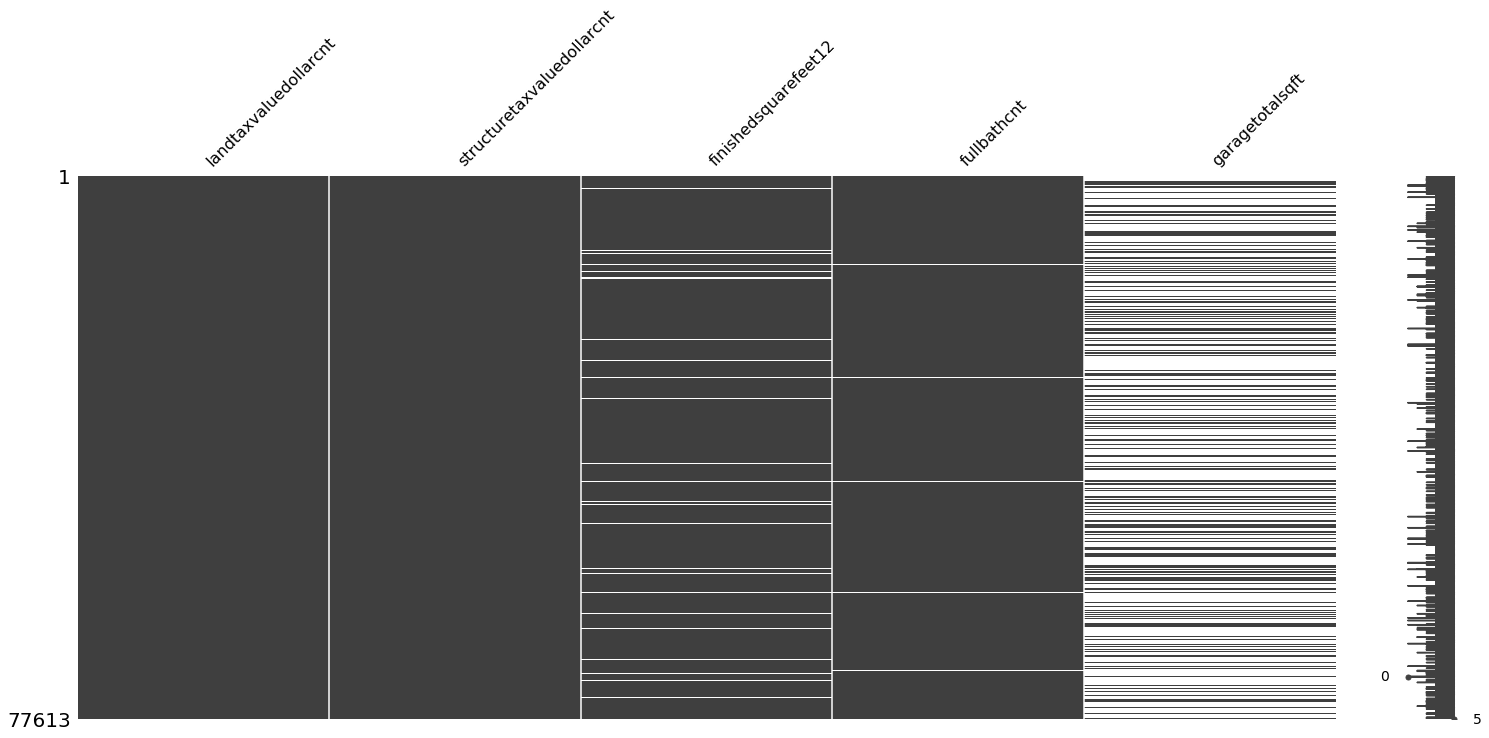

In [17]:
missingdata_df = df_model.columns[df_model.isnull().any()].tolist()
msno.matrix(df_model[missingdata_df])
# #msno.bar(merged_df[missingdata_df], color="blue", log=True, figsize=(30,18))
# msno.matrix(df_new[missingdata_df],figsize=(40,30))

# # Below are useful groups of categories for invesigating different behaviors
# fullFeatureList=list(nan_count_df.columns.values)
# print(fullFeatureList)

In [18]:
# missingdata_df = df_new.columns[df_new.isnull().any()].tolist()
#msno.matrix(merged_df[missingdata_df])
#msno.bar(merged_df[missingdata_df], color="blue", log=True, figsize=(30,18))
# msno.heatmap(df_new[missingdata_df],figsize=(40,30))

In [19]:
# df_new.hist(bins=50, figsize=(20,15)) 
# df_new.shape
# df_null=df_new.dropna()
# df_null.shape

## Select Model For Imputing Missing Data in Feature garagetotalsqft

In [20]:
# Now start again with the full dataframe (cleaned_df)
# We want to find the features most correlated with the feature we want to impute (garagetotalsqft)
top_correlated=cleaned_df.corr()['garagetotalsqft'].abs().sort_values(ascending=False).nlargest(20)
print(top_correlated)

garagetotalsqft                 1.000000
propertylandusetypeid           0.681290
garagecarcnt                    0.629749
finishedsquarefeet12            0.618204
bedroomcnt                      0.606354
calculatedfinishedsquarefeet    0.599186
heatingorsystemtypeid           0.597255
airconditioningtypeid           0.541975
fullbathcnt                     0.461738
bathroomcnt                     0.451538
calculatedbathnbr               0.442955
structuretaxvaluedollarcnt      0.412085
roomcnt                         0.404125
taxvaluedollarcnt               0.345202
taxamount                       0.334874
landtaxvaluedollarcnt           0.257996
regionidneighborhood            0.169940
lotsizesquarefeet               0.143567
yearbuilt                       0.093091
unitcnt                         0.091533
Name: garagetotalsqft, dtype: float64


In [21]:
# Of these let us investigate the amount of missing data
nan_investigation(cleaned_df[list(top_correlated.index)])

,garagetotalsqft,propertylandusetypeid,garagecarcnt,finishedsquarefeet12,bedroomcnt,calculatedfinishedsquarefeet,heatingorsystemtypeid,airconditioningtypeid,fullbathcnt,bathroomcnt,calculatedbathnbr,structuretaxvaluedollarcnt,roomcnt,taxvaluedollarcnt,taxamount,landtaxvaluedollarcnt,regionidneighborhood,lotsizesquarefeet,yearbuilt,unitcnt
Tot_Null,52093,34,52093,3690,34,235,28042,52606,650,34,650,149,34,35,39,36,46639,8292,304,26910
Tot_Not_Null,25520,77579,25520,73923,77579,77378,49571,25007,76963,77579,76963,77464,77579,77578,77574,77577,30974,69321,77309,50703
Perc_Null,0.671189,0.000438071,0.671189,0.0475436,0.000438071,0.00302784,0.361305,0.677799,0.00837489,0.000438071,0.00837489,0.00191978,0.000438071,0.000450955,0.000502493,0.00046384,0.600917,0.106838,0.00391687,0.34672


In [22]:
# As these will be used for imputing garagetotalsqft we drop any features missing more than 5% of data
cleaned_df = cleaned_df.drop(columns=['garagecarcnt','heatingorsystemtypeid','airconditioningtypeid',
                                      'regionidneighborhood','lotsizesquarefeet','unitcnt'])

In [23]:
# Now again investigate what is left, keeping only those above 10% correlation in list
top_correlated=cleaned_df.corr()['garagetotalsqft'].abs().sort_values(ascending=False).nlargest(13)
print(top_correlated)

garagetotalsqft                 1.000000
propertylandusetypeid           0.681290
finishedsquarefeet12            0.618204
bedroomcnt                      0.606354
calculatedfinishedsquarefeet    0.599186
fullbathcnt                     0.461738
bathroomcnt                     0.451538
calculatedbathnbr               0.442955
structuretaxvaluedollarcnt      0.412085
roomcnt                         0.404125
taxvaluedollarcnt               0.345202
taxamount                       0.334874
landtaxvaluedollarcnt           0.257996
Name: garagetotalsqft, dtype: float64


In [24]:
# Now investigate and remove redundant features based on correlation scores
impute_df = cleaned_df[list(top_correlated.index)]
impute_df.corr()

,garagetotalsqft,propertylandusetypeid,finishedsquarefeet12,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,bathroomcnt,calculatedbathnbr,structuretaxvaluedollarcnt,roomcnt,taxvaluedollarcnt,taxamount,landtaxvaluedollarcnt
garagetotalsqft,1.000000,-0.681290,0.618204,0.606354,0.599186,0.461738,0.451538,0.442955,0.412085,0.404125,0.345202,0.334874,0.257996
propertylandusetypeid,-0.681290,1.000000,-0.243274,-0.268852,-0.224098,-0.136277,-0.045047,-0.121997,-0.004484,-0.018288,-0.035930,-0.040769,-0.045596
finishedsquarefeet12,0.618204,-0.243274,1.000000,0.661766,1.000000,0.788357,0.803920,0.809971,0.720019,0.118470,0.606334,0.608228,0.469534
bedroomcnt,0.606354,-0.268852,0.661766,1.000000,0.631449,0.612911,0.635479,0.618283,0.296400,0.166964,0.239326,0.246367,0.178958
calculatedfinishedsquarefeet,0.599186,-0.224098,1.000000,0.631449,1.000000,0.786693,0.772863,0.807093,0.696255,0.097045,0.583155,0.587078,0.449920
fullbathcnt,0.461738,-0.136277,0.788357,0.612911,0.786693,1.000000,0.984499,0.984499,0.589588,-0.022999,0.472832,0.481077,0.356347
bathroomcnt,0.451538,-0.045047,0.803920,0.635479,0.772863,0.984499,1.000000,1.000000,0.566023,0.037741,0.461013,0.465966,0.347442
calculatedbathnbr,0.442955,-0.121997,0.809971,0.618283,0.807093,0.984499,1.000000,1.000000,0.604757,0.029855,0.484819,0.490269,0.365242
structuretaxvaluedollarcnt,0.412085,-0.004484,0.720019,0.296400,0.696255,0.589588,0.566023,0.604757,1.000000,-0.038935,0.796731,0.798992,0.590331
roomcnt,0.404125,-0.018288,0.118470,0.166964,0.097045,-0.022999,0.037741,0.029855,-0.038935,1.000000,0.001960,-0.027652,0.020576


calculatedfinishedsquarefeet and finishedsquarefeet12 have correlation of 1. We remove finishedsquarefeet12 as it is missing more data and has comparable correlation with imputation target.<br>
fullbathcnt and bathroomcnt have correlation of 0.984499. Both have comparable correlations with imputation target and are missing very little data. We will choose to remove fullbathcnt.<br>
calculatedbathnbr and bathroomcnt have correlation of 1. Comparable score and same amount of missing data. We choose to remove calculatedbathnbr.<br>
We also remove taxvaluedollarcnt as this is the full target for this project, and we do not want to bias the imputation by including this.<br>
taxamount and landtaxvaluedollarcnt have correlation of 0.944211. Comparable amount of missing data, but landtaxvaluedollarcnt has lower correlation with imputation target. We thus remove landtaxvaluedollarcnt.

In [25]:
impute_df=impute_df.drop(columns=['finishedsquarefeet12','fullbathcnt','calculatedbathnbr',
                                  'taxvaluedollarcnt','landtaxvaluedollarcnt'])
impute_df.corr()

,garagetotalsqft,propertylandusetypeid,bedroomcnt,calculatedfinishedsquarefeet,bathroomcnt,structuretaxvaluedollarcnt,roomcnt,taxamount
garagetotalsqft,1.000000,-0.681290,0.606354,0.599186,0.451538,0.412085,0.404125,0.334874
propertylandusetypeid,-0.681290,1.000000,-0.268852,-0.224098,-0.045047,-0.004484,-0.018288,-0.040769
bedroomcnt,0.606354,-0.268852,1.000000,0.631449,0.635479,0.296400,0.166964,0.246367
calculatedfinishedsquarefeet,0.599186,-0.224098,0.631449,1.000000,0.772863,0.696255,0.097045,0.587078
bathroomcnt,0.451538,-0.045047,0.635479,0.772863,1.000000,0.566023,0.037741,0.465966
structuretaxvaluedollarcnt,0.412085,-0.004484,0.296400,0.696255,0.566023,1.000000,-0.038935,0.798992
roomcnt,0.404125,-0.018288,0.166964,0.097045,0.037741,-0.038935,1.000000,-0.027652
taxamount,0.334874,-0.040769,0.246367,0.587078,0.465966,0.798992,-0.027652,1.000000


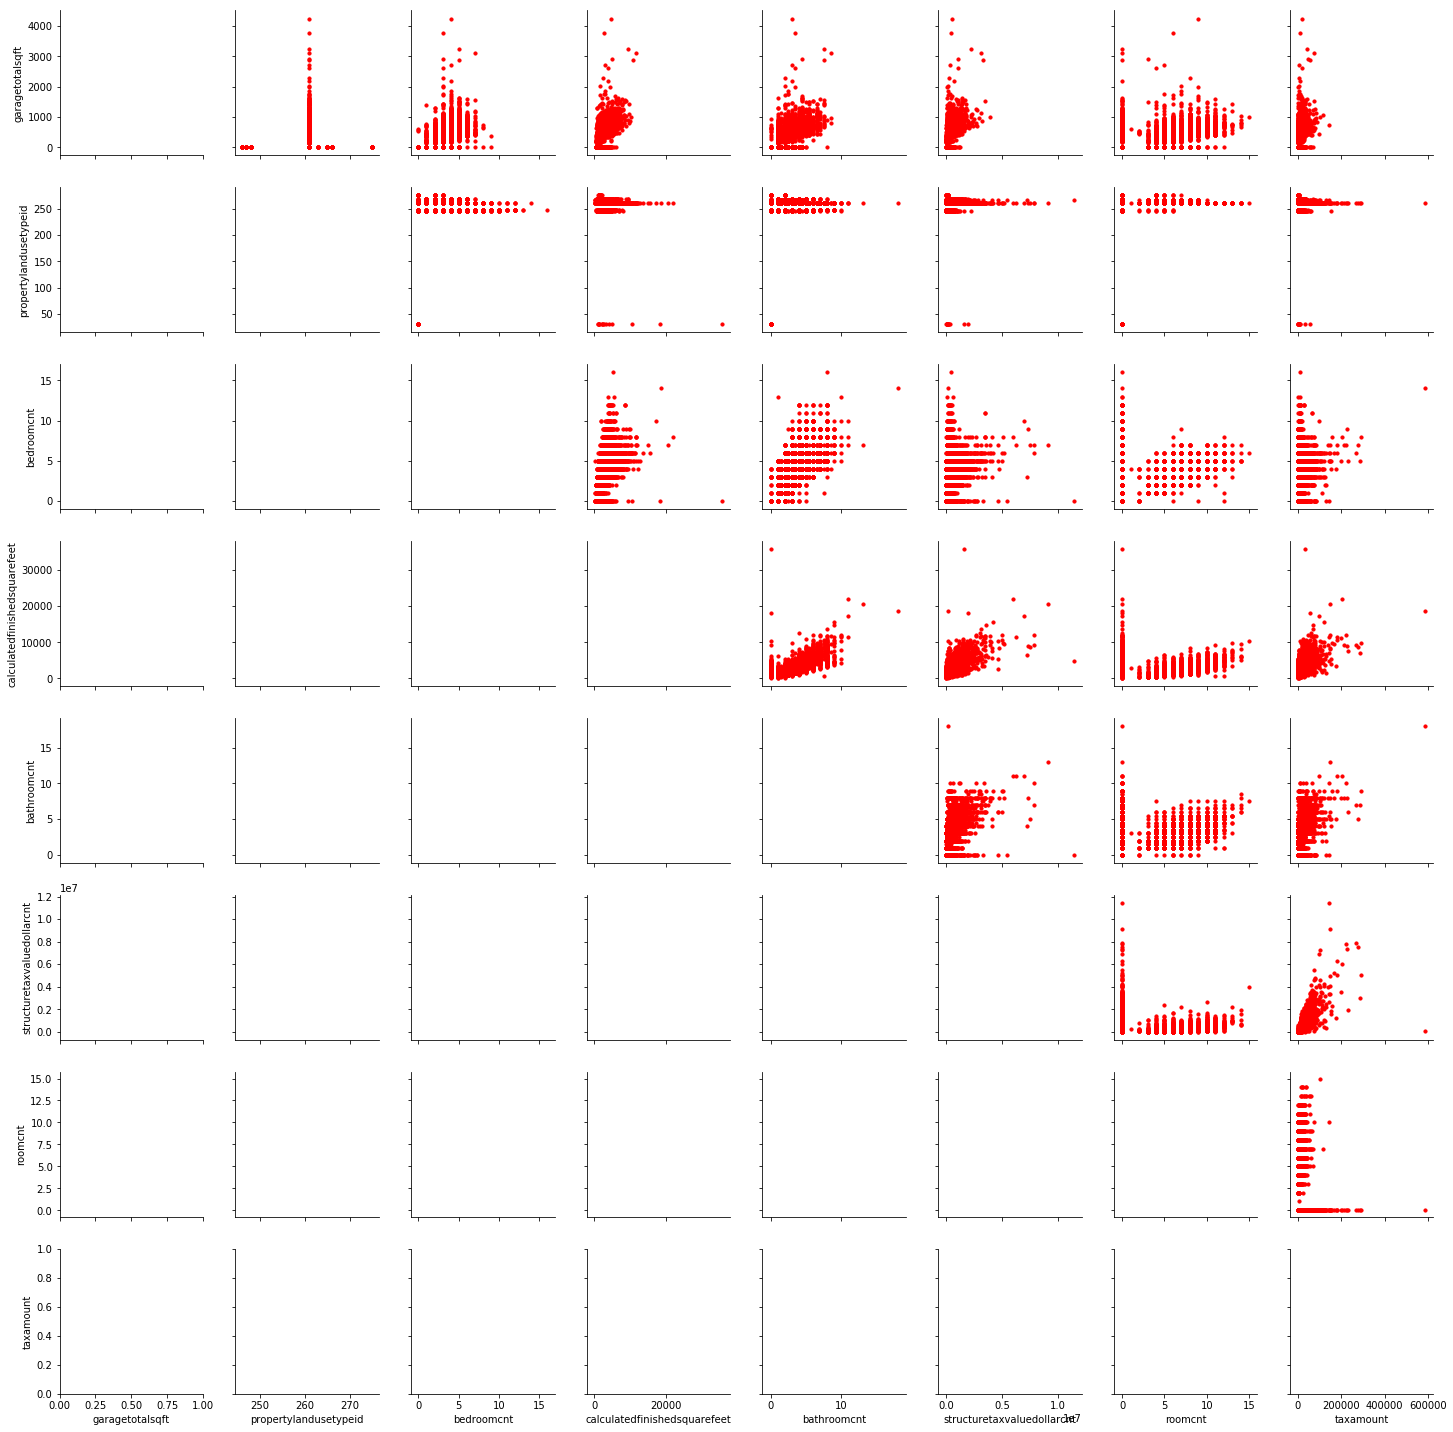

In [26]:
# We now create pairwise Seaborn plots to visually inspect for any signifcant covariance in the features.
create_pairwise_plots(impute_df)

I do not see any reason to suspect there is any significant covariance between these features.

In [27]:
top_correlated=impute_df.corr()['garagetotalsqft'].abs().sort_values(ascending=False)
print(top_correlated)

garagetotalsqft                 1.000000
propertylandusetypeid           0.681290
bedroomcnt                      0.606354
calculatedfinishedsquarefeet    0.599186
bathroomcnt                     0.451538
structuretaxvaluedollarcnt      0.412085
roomcnt                         0.404125
taxamount                       0.334874
Name: garagetotalsqft, dtype: float64


In [28]:
# Let us look at the missing data remaining in this model
nan_investigation(impute_df)

,garagetotalsqft,propertylandusetypeid,bedroomcnt,calculatedfinishedsquarefeet,bathroomcnt,structuretaxvaluedollarcnt,roomcnt,taxamount
Tot_Null,52093,34,34,235,34,149,34,39
Tot_Not_Null,25520,77579,77579,77378,77579,77464,77579,77574
Perc_Null,0.671189,0.000438071,0.000438071,0.00302784,0.000438071,0.00191978,0.000438071,0.000502493


## Now Add In Target and Features For Main Prediction to Create Full Dataframe

We now must add back in the features which will be included in the main prediction, including the main target.<br>
This is needed so that we can decide which rows will not be included in the final prediction.

In [29]:
full_exp_feature_list = list(['landtaxvaluedollarcnt','structuretaxvaluedollarcnt',
                              'finishedsquarefeet12','fullbathcnt','garagetotalsqft',
                              'taxvaluedollarcnt'])
impute_feature_list = list(['garagetotalsqft','propertylandusetypeid','bedroomcnt',
                            'calculatedfinishedsquarefeet','bathroomcnt','structuretaxvaluedollarcnt',
                            'roomcnt','taxamount'])
full_list = np.unique(full_exp_feature_list + impute_feature_list)
full_df = df_orig[full_list]

nan_investigation(full_df)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,garagetotalsqft,landtaxvaluedollarcnt,propertylandusetypeid,roomcnt,structuretaxvaluedollarcnt,taxamount,taxvaluedollarcnt
Tot_Null,34,34,235,3690,650,52093,36,34,34,149,39,35
Tot_Not_Null,77579,77579,77378,73923,76963,25520,77577,77579,77579,77464,77574,77578
Perc_Null,0.000438071,0.000438071,0.00302784,0.0475436,0.00837489,0.671189,0.00046384,0.000438071,0.000438071,0.00191978,0.000502493,0.000450955


In [30]:
# For the main invesigation we will be dropping all rows missing data for the following features:
# landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt
drop_list = ['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','finishedsquarefeet12','fullbathcnt']
df_fltrd=full_df.copy(deep=True)
df_fltrd.dropna(axis=0, how='any', thresh=None, subset=drop_list, inplace=True)

nan_investigation(df_fltrd)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,garagetotalsqft,landtaxvaluedollarcnt,propertylandusetypeid,roomcnt,structuretaxvaluedollarcnt,taxamount,taxvaluedollarcnt
Tot_Null,0,0,0,0,0,48468,0,0,0,0,4,0
Tot_Not_Null,73728,73728,73728,73728,73728,25260,73728,73728,73728,73728,73724,73728
Perc_Null,0,0,0,0,0,0.657389,0,0,0,0,5.42535e-05,0


In [31]:
# We now only keep the features corresponding to our imputation experiment
imputational_model = df_fltrd[impute_feature_list]

nan_investigation(imputational_model)

,garagetotalsqft,propertylandusetypeid,bedroomcnt,calculatedfinishedsquarefeet,bathroomcnt,structuretaxvaluedollarcnt,roomcnt,taxamount
Tot_Null,48468,0,0,0,0,0,0,4
Tot_Not_Null,25260,73728,73728,73728,73728,73728,73728,73724
Perc_Null,0.657389,0,0,0,0,0,0,5.42535e-05


In [32]:
# For the 4 missing values in taxamount it is safe to just replace them with the mean value for that feature
imputational_model['taxamount'].fillna((imputational_model['taxamount'].mean()), inplace=True)

nan_investigation(imputational_model)

,garagetotalsqft,propertylandusetypeid,bedroomcnt,calculatedfinishedsquarefeet,bathroomcnt,structuretaxvaluedollarcnt,roomcnt,taxamount
Tot_Null,48468,0,0,0,0,0,0,0
Tot_Not_Null,25260,73728,73728,73728,73728,73728,73728,73728
Perc_Null,0.657389,0,0,0,0,0,0,0


## Apply PCA to Full Imputation Feature Set

In [33]:
# Now separate the imputation target from the rest of the features
Y = imputational_model['garagetotalsqft'].values
X = imputational_model.drop(columns='garagetotalsqft').values

print(Y.shape)
print(X.shape)

(73728,)
(73728, 7)


In [34]:
# First Scale the feature matrix
X = StandardScaler().fit_transform(X)

In [35]:
#apply PCA to complete dataframe to visualize high dimensional features in low dimensions
mean_vec = np.mean(X, axis=0)
cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (X.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)
#now find eigenvalues and eigen vectors.Might be time consuming since we have high dimensional matrix.
# It is absolutely essential we remove feature redundancies before this
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Covariance matrix 
[[ 1.00001356 -0.40908589 -0.2458092  -0.00845821 -0.03187499 -0.1951026
  -0.08300406]
 [-0.40908589  1.00001356  0.66777241  0.59889294  0.35415036  0.21551756
   0.29316757]
 [-0.2458092   0.66777241  1.00001356  0.80980045  0.73134092  0.11904587
   0.61126197]
 [-0.00845821  0.59889294  0.80980045  1.00001356  0.63156239  0.05218782
   0.51542631]
 [-0.03187499  0.35415036  0.73134092  0.63156239  1.00001356 -0.04218755
   0.80294944]
 [-0.1951026   0.21551756  0.11904587  0.05218782 -0.04218755  1.00001356
  -0.02810238]
 [-0.08300406  0.29316757  0.61126197  0.51542631  0.80294944 -0.02810238
   1.00001356]]
Eigenvectors 
[[-0.13845948  0.6064271   0.61566479  0.32772428 -0.30137997 -0.15842771
  -0.10343874]
 [ 0.38408826 -0.38620711 -0.10454677  0.43986079 -0.68991496  0.08422545
  -0.12584177]
 [ 0.50037789 -0.03815882  0.011095    0.13163757  0.33614438 -0.74612585
  -0.2470172 ]
 [ 0.45558352  0.08697104  0.17595363  0.42846207  0.41157147  0.40302436
   

In [36]:
#Also check if the correlation matrix gives the same set of eigen vectors
cor_mat1 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

#Confirm that both approaches gives you the same result

Eigenvectors 
[[-0.13845948  0.6064271   0.61566479  0.32772428 -0.30137997 -0.15842771
  -0.10343874]
 [ 0.38408826 -0.38620711 -0.10454677  0.43986079 -0.68991496  0.08422545
  -0.12584177]
 [ 0.50037789 -0.03815882  0.011095    0.13163757  0.33614438 -0.74612585
  -0.2470172 ]
 [ 0.45558352  0.08697104  0.17595363  0.42846207  0.41157147  0.40302436
   0.48838567]
 [ 0.44980609  0.29640541  0.01596123 -0.31488578  0.05223678  0.46246964
  -0.62753777]
 [ 0.06523507 -0.55525567  0.75958419 -0.32909665  0.02700812  0.03784845
  -0.00091043]
 [ 0.41084021  0.27911493 -0.04148679 -0.53921556 -0.38385573 -0.18265717
   0.52926528]]

Eigenvalues 
[3.49269912 1.39963418 0.82667923 0.70426483 0.26654009 0.12531623
 0.18486633]


In [37]:
# Now isolate the features which are your principal components
# The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.
# In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top 𝑘 eigenvectors.
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.4926991180984786
1.3996341777846673
0.8266792265439393
0.7042648286115643
0.2665400927441721
0.18486632724808746
0.12531622896909392


In [38]:
#the next question is "how many principal components are we going to choose for our new feature subspace?" 
# A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. 
# The explained variance tells us how much information (variance) can be attributed to each of the principal components.
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
num_eig_pairs = len(eig_pairs)+1

trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,num_eig_pairs)],
    y=var_exp,
    name='Individual'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,num_eig_pairs)], 
    y=cum_var_exp,
    name='Cumulative'
)

data = [trace1, trace2]

layout=dict(
    title='Explained variance by different principal components',
    yaxis=dict(
        title='Explained variance in percent'
    ),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Explained Variance',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='exploratory-vis-histogram')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~bmoore49/0 or inside your plot.ly account where it is named 'exploratory-vis-histogram'


In [39]:
#From the above we have chosen to keep PC1, PC2, PC3, PC4, and PC5
# This combination explains 96.3% of the variance

eigenvector_length = X.shape[1]
# print(eig_pairs)

matrix_w = np.hstack((eig_pairs[0][1].reshape(eigenvector_length,1), 
                      eig_pairs[1][1].reshape(eigenvector_length,1),
                      eig_pairs[2][1].reshape(eigenvector_length,1),
                      eig_pairs[3][1].reshape(eigenvector_length,1),
                      eig_pairs[4][1].reshape(eigenvector_length,1),
                     ))

print('Projection matrix W:\n', matrix_w)

Projection matrix W:
 [[-0.13845948  0.6064271   0.61566479  0.32772428 -0.30137997]
 [ 0.38408826 -0.38620711 -0.10454677  0.43986079 -0.68991496]
 [ 0.50037789 -0.03815882  0.011095    0.13163757  0.33614438]
 [ 0.45558352  0.08697104  0.17595363  0.42846207  0.41157147]
 [ 0.44980609  0.29640541  0.01596123 -0.31488578  0.05223678]
 [ 0.06523507 -0.55525567  0.75958419 -0.32909665  0.02700812]
 [ 0.41084021  0.27911493 -0.04148679 -0.53921556 -0.38385573]]


In [40]:
# We now project our feature matrix into this new space
X_proj = X.dot(matrix_w)
print(X_proj.shape)

(73728, 5)


In [41]:
# Now create test and train datasets
# Note we chose to make the test size the same percentage (50.0%) as the amount of missing data we have
X_train_full, X_test_full, Y_train_full, Y_test_full = train_test_split(X_proj, Y, test_size = 0.50, random_state=42)

## Apply PCA to Imputation Features With Rows to Be Imputed Removed

In [42]:
# For experimenting on which imputation technique is most effective we want to know the actual label for each row
# We thus remove all data which is actually missing from garagetotalsqft
imputational_model_cleaned = imputational_model.dropna()

In [43]:
# Now separate the imputation target from the rest of the features
Y = imputational_model_cleaned['garagetotalsqft'].values
X = imputational_model_cleaned.drop(columns='garagetotalsqft').values

print(Y.shape)
print(X.shape)

(25260,)
(25260, 7)


In [44]:
# First Scale the feature matrix
X = StandardScaler().fit_transform(X)

In [45]:
#apply PCA to complete dataframe to visualize high dimensional features in low dimensions
mean_vec = np.mean(X, axis=0)
cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (X.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

#now find eigenvalues and eigen vectors.Might be time consuming since we have high dimensional matrix.
# It is absolutely essential we remove feature redundancies before this
print('\n')
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Covariance matrix 
[[ 1.00003959 -0.54827453 -0.39357117 -0.23822808 -0.17528231 -0.47658342
  -0.17625251]
 [-0.54827453  1.00003959  0.65683597  0.60756412  0.41223592  0.35984394
   0.33713638]
 [-0.39357117  0.65683597  1.00003959  0.84482294  0.82717596  0.11619934
   0.68245548]
 [-0.23822808  0.60756412  0.84482294  1.00003959  0.73927787 -0.0101067
   0.6114909 ]
 [-0.17528231  0.41223592  0.82717596  0.73927787  1.00003959 -0.14732745
   0.8065856 ]
 [-0.47658342  0.35984394  0.11619934 -0.0101067  -0.14732745  1.00003959
  -0.10070321]
 [-0.17625251  0.33713638  0.68245548  0.6114909   0.8065856  -0.10070321
   1.00003959]]


Eigenvectors 
[[ 2.43673352e-01  5.32411260e-01  3.82319975e-01  6.66530115e-01
  -2.24084084e-01  7.43056849e-02 -1.04859811e-01]
 [-3.78600854e-01 -3.36055217e-01  5.18722133e-01 -1.26761435e-01
  -6.55639727e-01 -7.44863750e-02 -1.52235016e-01]
 [-4.85802499e-01  2.79090321e-02  8.87818519e-02  7.61761053e-02
   3.05402314e-01  7.53221290e-01 -2.98193

In [46]:
#Also check if the correlation matrix gives the same set of eigen vectors
cor_mat1 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

#Confirm that both approaches gives you the same result

Eigenvectors 
[[ 2.43673352e-01  5.32411260e-01  3.82319975e-01  6.66530115e-01
  -2.24084084e-01  7.43056849e-02 -1.04859811e-01]
 [-3.78600854e-01 -3.36055217e-01  5.18722133e-01 -1.26761435e-01
  -6.55639727e-01 -7.44863750e-02 -1.52235016e-01]
 [-4.85802499e-01  2.79090321e-02  8.87818519e-02  7.61761053e-02
   3.05402314e-01  7.53221290e-01 -2.98193086e-01]
 [-4.49639989e-01  1.18333726e-01  4.14761711e-01  9.23380125e-02
   3.99517792e-01 -2.74311159e-01  6.06964865e-01]
 [-4.41306845e-01  2.89430474e-01 -2.10950492e-01  6.41036457e-02
   1.26812050e-01 -5.60224550e-01 -5.85607411e-01]
 [-7.05780504e-02 -6.56341656e-01 -2.04302764e-01  7.09404493e-01
   9.02603145e-02 -1.05323161e-01  3.50403970e-04]
 [-3.99213616e-01  2.72523372e-01 -5.64455103e-01  1.34074699e-01
  -4.92757153e-01  1.46277159e-01  4.06899611e-01]]

Eigenvalues 
[3.82023757 1.67447535 0.51790415 0.46675816 0.26056639 0.0896404
 0.17041798]


They both give the same eigenvalues and eigenvectors, so everything looks fine.

In [47]:
# Now isolate the features which are your principal components
# The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.
# In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top 𝑘 eigenvectors.
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.8202375658572336
1.6744753521927012
0.517904151099188
0.4667581606362345
0.2605663900268136
0.1704179793299252
0.0896404008579098


In [48]:
#the next question is "how many principal components are we going to choose for our new feature subspace?" 
# A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. 
# The explained variance tells us how much information (variance) can be attributed to each of the principal components.
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
num_eig_pairs = len(eig_pairs)+1

trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,num_eig_pairs)],
    y=var_exp,
    name='Individual'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,num_eig_pairs)], 
    y=cum_var_exp,
    name='Cumulative'
)

data = [trace1, trace2]

layout=dict(
    title='Explained variance by different principal components',
    yaxis=dict(
        title='Explained variance in percent'
    ),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Explained Variance',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='exploratory-vis-histogram')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~bmoore49/0 or inside your plot.ly account where it is named 'exploratory-vis-histogram'


In [49]:
#From the above we have chosen to keep PC1, PC2, PC3, PC4, and PC5
# This combination explains 96.3% of the variance

eigenvector_length = X.shape[1]
# print(eig_pairs)

matrix_w = np.hstack((eig_pairs[0][1].reshape(eigenvector_length,1), 
                      eig_pairs[1][1].reshape(eigenvector_length,1),
                      eig_pairs[2][1].reshape(eigenvector_length,1),
                      eig_pairs[3][1].reshape(eigenvector_length,1),
                      eig_pairs[4][1].reshape(eigenvector_length,1),
                     ))

print('Projection matrix W:\n', matrix_w)

Projection matrix W:
 [[ 0.24367335  0.53241126  0.38231997  0.66653011 -0.22408408]
 [-0.37860085 -0.33605522  0.51872213 -0.12676143 -0.65563973]
 [-0.4858025   0.02790903  0.08878185  0.07617611  0.30540231]
 [-0.44963999  0.11833373  0.41476171  0.09233801  0.39951779]
 [-0.44130684  0.28943047 -0.21095049  0.06410365  0.12681205]
 [-0.07057805 -0.65634166 -0.20430276  0.70940449  0.09026031]
 [-0.39921362  0.27252337 -0.5644551   0.1340747  -0.49275715]]


In [50]:
# We now project our feature matrix into this new space
X_proj = X.dot(matrix_w)
print(X_proj.shape)

(25260, 5)


In [51]:
# Now create test and train datasets
# Note we chose to make the test size 50.0%
X_train_clnd, X_test_clnd, Y_train_clnd, Y_test_clnd = train_test_split(X_proj, Y, test_size = 0.50, random_state=42)

## Experiment 1 - Mean Imputation

In [52]:
# We now see what results we get for just replacing all missing values with mean of remaining part of dataset

# Calculate average value from train set
mean_Y = np.mean(Y_train_clnd)
# Place this value in the predicted test set
Y_test_pred = [mean_Y for elem in Y_test_clnd]

# Calculate the MSE and r^2 value for Mean Imputation
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test_clnd, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test_clnd,Y_test_pred))

The mean squared error of this prediction is 68252.112971
The r^2 value for this prediction is -0.000736


In [53]:
# Now use this to fill in actual data in the main model and use polynomial regression
# to make a prediction on the actual target (taxvaluedollarcnt)

# Make copy of imputational model
imputational_model_meanImp = imputational_model.copy(deep=True)

# Apply mean imputation to fill out missing values
imputational_model_meanImp['garagetotalsqft'].fillna((imputational_model_meanImp['garagetotalsqft'].mean()), inplace=True)

Y_full = imputational_model_meanImp['garagetotalsqft'].values

In [54]:
# We now make copy of the full model dataframe and drop all nan vaues from other features
drop_list = ['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','finishedsquarefeet12','fullbathcnt']
df_model_Mean = df_orig[full_exp_feature_list] # Includes all features, including target
df_model_Mean.dropna(axis=0, how='any', thresh=None, subset=drop_list, inplace=True)

# We now replace the garagetotalsqft in the above dataframe with the imputed one we just calculated
df_model_Mean = df_model_Mean.drop(columns='garagetotalsqft')
df_model_Mean['garagetotalsqft'] = Y_full

nan_investigation(df_model_Mean)

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,taxvaluedollarcnt,garagetotalsqft
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,73728,73728,73728,73728,73728,73728
Perc_Null,0,0,0,0,0,0


## Experiment 2 - Expectation Maximization

In [55]:
from sklearn.mixture import GaussianMixture

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [56]:
# # Now use GridSearchCV to choose best model based on hyperparamters

# param_grid = {'n_components': [3, 5, 9, 15, 29, 45, 75, 99, 131],
#               'max_iter': [10, 100, 1000, 10000, 100000, 1000000, 10000000]}

# gmm = GaussianMixture()

# gmm_cv = GridSearchCV(gmm, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs = -1, verbose = 2)
# gmm_cv.fit(X_train_clnd, Y_train_clnd)

# print("Best Score (r^2 value): %f" % gmm_cv.best_score_)
# print("Optimal Hyperparameter Values: ", gmm_cv.best_params_)

The above results give the following optimal values:<br>
max_iter_opt = 100 <br>
n_components_opt = 131

In [57]:
# Below are the optimal hyperparameters
max_iter_opt = 100 
n_components_opt = 2

# Implement Gausian Mixture Model
gmm = GaussianMixture(n_components=n_components_opt, max_iter=max_iter_opt).fit(X_train_clnd)

# These are the predictions for each row as to what class it is in
prediction_gmm = gmm.predict(X_train_clnd)
# Get list of all unique classes
unique_classes = np.unique(prediction_gmm)
mean_val = np.zeros(len(unique_classes))
# Go through each class and calculate mean imputation value for each class, for putting in for predictions below
for unique_class in unique_classes:
    mean_val[unique_class] = np.mean([Y_train_clnd[index] for index in range(len(Y_train_clnd)) if prediction_gmm[index]==unique_class])

In [58]:
# Now make a prediction on the test set

Y_test_pred = gmm.predict(X_test_clnd)

# Go through and replace each predicted class with its associated mean class value
for row in range(len(Y_test_pred)):
        Y_test_pred[row] = mean_val[ prediction_gmm[row] ]

print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test_clnd, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test_clnd,Y_test_pred))

The mean squared error of this prediction is 117611.450198
The r^2 value for this prediction is -0.724459


In [59]:
# Now use this to fill in actual data in the main model and use polynomial regression
# to make a prediction on the actual target (taxvaluedollarcnt)

# Create dataframe with all rows not missing any values for imputation target
data_present_df = imputational_model[pd.notnull(imputational_model['garagetotalsqft'])]

# Pull out full target Vector and full feature matrix
Y_full = imputational_model['garagetotalsqft'].values
X_full = imputational_model.drop(columns='garagetotalsqft').values

# Now create target and feature arrays for both cases
Y_present = data_present_df['garagetotalsqft'].values
X_present = data_present_df.drop(columns='garagetotalsqft').values



gmm = GaussianMixture(n_components=n_components_opt, max_iter=max_iter_opt).fit(X_present)
gmm.fit(X_present)

# Create class predictions for data present
prediction_gmm = gmm.predict(X_present)

# Come up with mean value for each class corresponding to above grouping
unique_classes = np.unique(prediction_gmm)
mean_val = np.zeros(len(unique_classes))
for unique_class in unique_classes:
    mean_val[unique_class] = np.mean([Y_present[index] for index in range(len(Y_present)) if prediction_gmm[index]==unique_class])

# Now make class predictions for values we do not know
prediction_gmm = gmm.predict(X_full)

# Go through each actual and replace any missing values with those corresponding to their predictions
for row in range(len(Y_full)):
    if math.isnan(Y_full[row]):
        Y_full[row] = mean_val[ prediction_gmm[row] ]

In [60]:
# We now make copy of the full model dataframe and drop all nan vaues from other features
drop_list = ['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','finishedsquarefeet12','fullbathcnt']
df_model_EM = df_orig[full_exp_feature_list] # Includes all features, including target
df_model_EM.dropna(axis=0, how='any', thresh=None, subset=drop_list, inplace=True)

# We now replace the garagetotalsqft in the above dataframe with the imputed one we just calculated
df_model_EM = df_model_EM.drop(columns='garagetotalsqft')
df_model_EM['garagetotalsqft'] = Y_full

nan_investigation(df_model_EM)

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,taxvaluedollarcnt,garagetotalsqft
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,73728,73728,73728,73728,73728,73728
Perc_Null,0,0,0,0,0,0


## Experiment 3 - KNN Imputation

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [61]:
# # Now use GridSearchCV to choose best model based on hyperparamters

# param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 21, 23, 33, 35, 39, 43, 49],
#               'p': [1, 2, 3, 5, 10, 100, 200, 300],'weights': ["uniform", "distance"]}

# knn = KNeighborsRegressor()

# knn_cv = GridSearchCV(knn, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs = -1, verbose = 2)
# knn_cv.fit(X_train_clnd, Y_train_clnd)

# print("Best Score (r^2 value): %f" % knn_cv.best_score_)
# print("Optimal Hyperparameter Values: ", knn_cv.best_params_)

The above results give the following optimal values:<br>
optimal r^2 value: 0.832346<br>
n_neighbors: 35<br>
p: 2<br>
weights: distance

In [62]:
# Now train model using the above-found optimal hyper-parameters

# Using best hyperparameter values found above we find the optimum model
n_neighbors_opt = 35
p_opt = 2
weights_opt = 'distance'

knn_cv = KNeighborsRegressor(n_neighbors=n_neighbors_opt, p=p_opt,weights=weights_opt)
knn_cv.fit(X_train_clnd, Y_train_clnd)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=35, p=2,
          weights='distance')

In [63]:
# Predict missing values in X_test
Y_test_pred = knn_cv.predict(X_test_clnd)

print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test_clnd, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test_clnd,Y_test_pred))

The mean squared error of this prediction is 10756.111037
The r^2 value for this prediction is 0.842290


In [64]:
# Now use this to fill in actual data in the main model and use polynomial regression
# to make a prediction on the actual target (taxvaluedollarcnt)

# Create dataframe with all rows not missing any values for imputation target
data_present_df = imputational_model[pd.notnull(imputational_model['garagetotalsqft'])]

# Pull out full target Vector and full feature matrix
Y_full = imputational_model['garagetotalsqft'].values
X_full = imputational_model.drop(columns='garagetotalsqft').values

# Now create target and feature arrays for both cases
Y_present = data_present_df['garagetotalsqft'].values
X_present = data_present_df.drop(columns='garagetotalsqft').values

# Using above-found hyperparameters we fit our data, using the 
knn_cv = KNeighborsRegressor(n_neighbors=n_neighbors_opt, p=p_opt,weights=weights_opt)
knn_cv.fit(X_present, Y_present)

# Now make a prediction for the missing values in the imputation target
Y_full_pred = knn_cv.predict(X_full)

# Now replace missing values in Y_full with their predicted values
# Y_full = [elem for elem in Y_full_pred if math.isnan(Y_full)]
for row in range(len(Y_full)):
    if math.isnan(Y_full[row]):
        Y_full[row] = Y_full_pred[row]

In [65]:
# We now make copy of the full model dataframe and drop all nan vaues from other features
drop_list = ['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','finishedsquarefeet12','fullbathcnt']
df_model_KNN = df_orig[full_exp_feature_list] # Includes all features, including target
df_model_KNN.dropna(axis=0, how='any', thresh=None, subset=drop_list, inplace=True)

# We now replace the garagetotalsqft in the above dataframe with the imputed one we just calculated
df_model_KNN = df_model_KNN.drop(columns='garagetotalsqft')
df_model_KNN['garagetotalsqft'] = Y_full

nan_investigation(df_model_KNN)

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,taxvaluedollarcnt,garagetotalsqft
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,73728,73728,73728,73728,73728,73728
Perc_Null,0,0,0,0,0,0


## Experiment 4 - Polynomial Regression

In [66]:
def vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test):
    mse_train, mse_test = [], []

    for degree in degreeList:
        print('Modeling data using degree: %i' %degree)

        # Create model for current degree polynomial being considered
        model = make_pipeline(PolynomialFeatures(degree, include_bias=False),
                              StandardScaler(), LinearRegression()) 

        # Fit model using the training data for current degree of polynomial
        model.fit(X_train, Y_train)

        # Make prediction for both training and testing datasets
        Y_train_predicted = model.predict(X_train)
        Y_test_predicted = model.predict(X_test)

        # These keep track of MSE for testing and training datasets for each polynomial order considered
        mse_train.append(mean_squared_error(Y_train, Y_train_predicted))
        mse_test.append(mean_squared_error(Y_test, Y_test_predicted))

    # Below plots the “rmse vs. degree”
    plt.figure(figsize=(10, 6))
    plt.plot(degreeList, mse_test, "ro-", alpha=1.0, linewidth=1.0, label="Test MSE")
    plt.plot(degreeList, mse_train, "bo-", alpha=1.0, linewidth=1.0, label="Train MSE")    
    plt.legend(loc="best", fontsize=14) 
    plt.xlabel("Degree")
    plt.ylabel("MSE")
    plt.title("MSE for Varying Degree")
#     plt.ylim(bottom = 0, top=40000) # Adjust the y range to better understand which order of polynomial really becomes a problem
    plt.show()

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3
Modeling data using degree: 4
Modeling data using degree: 5


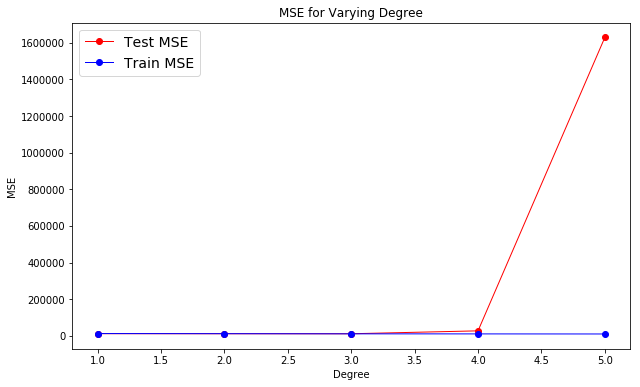

In [67]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3,4,5]
vary_degree_plot(degreeList,X_train_clnd,Y_train_clnd,X_test_clnd,Y_test_clnd)

In [68]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
# We choose 1st order
poly_degree = 1

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly_clnd = poly_features.fit_transform(X_train_clnd)

scaler = StandardScaler().fit(X_train_poly_clnd)
X_train_poly_standardized_clnd = scaler.transform(X_train_poly_clnd)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [69]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train_clnd, Y_train_clnd)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

From the above we will use the following hyperparameters for linear regression:<br>
 alpha_opt = 0.001 # Regularization Parameter<br>
 learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
 l1_ratio_opt = 0.5<br>
 max_iter_opt = 1000<br>
 eta0_opt = 0.1 # learning rate<br>
 penalty_opt = 'elasticnet'

In [70]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
learning_rate_opt = 'optimal' # (constant or updated during descent)
l1_ratio_opt = 0.5
max_iter_opt = 1000
eta0_opt = 0.1 # learning rate
penalty_opt = 'elasticnet'

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train_clnd, Y_train_clnd)

Y_test_pred = lin_reg_sgd.predict(X_test_clnd)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test_clnd, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test_clnd,Y_test_pred))

The mean squared error of this prediction is 11663.561306
The r^2 value for this prediction is 0.828985


In [71]:
# Now use this to fill in actual data in the main model and use polynomial regression
# to make a prediction on the actual target (taxvaluedollarcnt)

# Create dataframe with all rows not missing any values for imputation target
data_present_df = imputational_model[pd.notnull(imputational_model['garagetotalsqft'])]

# Pull out full target Vector and full feature matrix
Y_full = imputational_model['garagetotalsqft'].values
X_full = imputational_model.drop(columns='garagetotalsqft').values

# Now create target and feature arrays for both cases
Y_present = data_present_df['garagetotalsqft'].values
X_present = data_present_df.drop(columns='garagetotalsqft').values

# Using above-found hyperparameters we fit our data, using the 
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)
lin_reg_sgd.fit(X_present, Y_present)

# Now make a prediction for the missing values in the imputation target
Y_full_pred = knn_cv.predict(X_full)

# Now replace missing values in Y_full with their predicted values
# Y_full = [elem for elem in Y_full_pred if math.isnan(Y_full)]
for row in range(len(Y_full)):
    if math.isnan(Y_full[row]):
        Y_full[row] = Y_full_pred[row]

In [72]:
# We now make copy of the full model dataframe and drop all nan vaues from other features
drop_list = ['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','finishedsquarefeet12','fullbathcnt']
df_model_linReg = df_orig[full_exp_feature_list] # Includes all features, including target
df_model_linReg.dropna(axis=0, how='any', thresh=None, subset=drop_list, inplace=True)

# We now replace the garagetotalsqft in the above dataframe with the imputed one we just calculated
df_model_linReg = df_model_linReg.drop(columns='garagetotalsqft')
df_model_linReg['garagetotalsqft'] = Y_full

nan_investigation(df_model_linReg)

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,taxvaluedollarcnt,garagetotalsqft
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,73728,73728,73728,73728,73728,73728
Perc_Null,0,0,0,0,0,0


## Experiment 5 - Random Forest

This is a possible improvement on the above polynomial regression imputation approach.<br>
This will select random subsamples of the train data and calculate an optimal regression formula.<br>
To select these we have implemented bootstrapping with replacement, to get a more unbiased opinion from the train data.<br>
Each node of a tree makes a decision, which is then re-evaluated by below branches until a low enough MSE is reached, or the maximum size is reached.<br>
Each tree may also be given a different subselection of features to use.<br>
The final output is then the average of all trees created.

In [73]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3
Modeling data using degree: 4
Modeling data using degree: 5


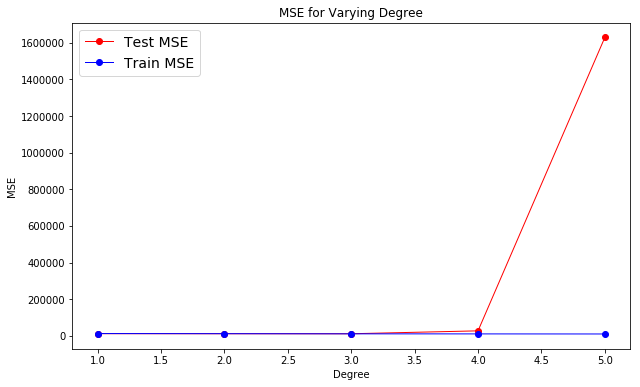

In [74]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3,4,5]
vary_degree_plot(degreeList,X_train_clnd,Y_train_clnd,X_test_clnd,Y_test_clnd)

In [75]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
# It looks like it is very similar up to degree 1, with variations possibly due to noise
# We therefore choose 1st order
poly_degree = 1

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly_clnd = poly_features.fit_transform(X_train_clnd)

scaler = StandardScaler().fit(X_train_poly_clnd)
X_train_poly_standardized_clnd = scaler.transform(X_train_poly_clnd)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [76]:
# # We first set up our hyperparameters we will try for optimizing this regression with Random Forest

# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3, 4, 5],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# # Create a based model
# rf = RandomForestRegressor()

# # Initialize the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='neg_mean_squared_error',
#                           cv = 5, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
# grid_search.fit(X_train_poly_standardized_clnd, Y_train_clnd)

# # Print the optimal parameters
# grid_search.best_params_

The above shows that the optimal hyperparameters for a linear model are:<br>
bootstrap_opt = True<br>
max_depth_opt = 110<br>
max_features_opt = 3<br>
min_samples_leaf_opt = 4<br>
min_samples_split_opt = 12<br>
n_estimators_opt = 300

In [77]:
# Instantiate model with above-indicated hyperparameters
bootstrap_opt = True
max_depth_opt = 110
max_features_opt = 3
min_samples_leaf_opt = 4
min_samples_split_opt = 12
n_estimators_opt = 300

random_forest = RandomForestRegressor(bootstrap=bootstrap_opt, max_depth=max_depth_opt,
                                      max_features=max_features_opt, min_samples_leaf=min_samples_leaf_opt,
                                      min_samples_split=min_samples_split_opt, n_estimators=n_estimators_opt,
                                      random_state = 42)

# Train the model on training data
random_forest.fit(X_train_clnd, Y_train_clnd);

In [78]:
# Use the forest's predict method on the test data
Y_test_pred = random_forest.predict(X_test_clnd)

print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test_clnd, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test_clnd,Y_test_pred))

The mean squared error of this prediction is 10721.895134
The r^2 value for this prediction is 0.842792


In [79]:
# Now use this to fill in actual data in the main model and use polynomial regression
# to make a prediction on the actual target (taxvaluedollarcnt)

# Create dataframe with all rows not missing any values for imputation target
data_present_df = imputational_model[pd.notnull(imputational_model['garagetotalsqft'])]

# Pull out full target Vector and full feature matrix
Y_full = imputational_model['garagetotalsqft'].values
X_full = imputational_model.drop(columns='garagetotalsqft').values

# Now create target and feature arrays for both cases
Y_present = data_present_df['garagetotalsqft'].values
X_present = data_present_df.drop(columns='garagetotalsqft').values

# Using above-found hyperparameters we fit our data, using the 
random_forest = RandomForestRegressor(bootstrap=bootstrap_opt, max_depth=max_depth_opt,
                                      max_features=max_features_opt, min_samples_leaf=min_samples_leaf_opt,
                                      min_samples_split=min_samples_split_opt, n_estimators=n_estimators_opt,
                                      random_state = 42)
random_forest.fit(X_present, Y_present);

# Now make a prediction for the missing values in the imputation target
Y_full_pred = random_forest.predict(X_full)

# Now replace missing values in Y_full with their predicted values
# Y_full = [elem for elem in Y_full_pred if math.isnan(Y_full)]
for row in range(len(Y_full)):
    if math.isnan(Y_full[row]):
        Y_full[row] = Y_full_pred[row]

In [80]:
# We now make copy of the full model dataframe and drop all nan vaues from other features
drop_list = ['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','finishedsquarefeet12','fullbathcnt']
df_model_randForest = df_orig[full_exp_feature_list] # Includes all features, including target
df_model_randForest.dropna(axis=0, how='any', thresh=None, subset=drop_list, inplace=True)

# We now replace the garagetotalsqft in the above dataframe with the imputed one we just calculated
df_model_randForest = df_model_randForest.drop(columns='garagetotalsqft')
df_model_randForest['garagetotalsqft'] = Y_full

nan_investigation(df_model_randForest)

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,taxvaluedollarcnt,garagetotalsqft
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,73728,73728,73728,73728,73728,73728
Perc_Null,0,0,0,0,0,0


## Experiment 6 - Artificial Neural Network

In [81]:
#what if we used a dense neural network instead
# Define Feature Columns for the Linear Regressor
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [82]:
# define our model,one hidden layer with one output layer
def base_architecture_1hidden(num_neurons_layer1, X_train_clnd):
    #create model
    model=Sequential()
    #the input layer
    model.add(Dense(X_train_clnd.shape[1], input_dim=X_train_clnd.shape[1],
                    kernel_initializer='normal', activation='relu'))
    # The Hidden Layers :
    model.add(Dense(int(num_neurons_layer1), kernel_initializer='normal',activation='relu'))
    # the Output Layers:
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile the network :
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [83]:
# define our model,two densely connected layers with one output layer
def base_architecture_2hidden(num_neurons_layer1,num_neurons_layer2,X_train_clnd):
    #create model
    model=Sequential()
    #the input layer
    model.add(Dense(X_train_clnd.shape[1], input_dim=X_train_clnd.shape[1],
                    kernel_initializer='normal', activation='relu'))
    # The Hidden Layers :
    model.add(Dense(int(num_neurons_layer1), kernel_initializer='normal',activation='relu'))
    model.add(Dense(int(num_neurons_layer2), kernel_initializer='normal',activation='relu'))
    # the Output Layers:
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile the network :
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [84]:
# define our model,three densely connected layers with one output layer
def base_architecture_3hidden(num_neurons_layer1,num_neurons_layer2,num_neurons_layer3,X_train_clnd):
    #create model
    model=Sequential()
    #the input layer
    model.add(Dense(X_train_clnd.shape[1], input_dim=X_train_clnd.shape[1],
                    kernel_initializer='normal', activation='relu'))
    # The Hidden Layers :
    model.add(Dense(int(num_neurons_layer1), kernel_initializer='normal',activation='relu'))
    model.add(Dense(int(num_neurons_layer2), kernel_initializer='normal',activation='relu'))
    model.add(Dense(int(num_neurons_layer3), kernel_initializer='normal',activation='relu'))
    # the Output Layers:
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile the network :
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [85]:
# define our model,three densely connected layers with one output layer
def base_architecture_4hidden(num_neurons_layer1,num_neurons_layer2,num_neurons_layer3,
                              num_neurons_layer4,X_train_clnd):
    #create model
    model=Sequential()
    #the input layer
    model.add(Dense(X_train_clnd.shape[1], input_dim=X_train_clnd.shape[1],
                    kernel_initializer='normal', activation='relu'))
    # The Hidden Layers :
    model.add(Dense(int(num_neurons_layer1), kernel_initializer='normal',activation='relu'))
    model.add(Dense(int(num_neurons_layer2), kernel_initializer='normal',activation='relu'))
    model.add(Dense(int(num_neurons_layer3), kernel_initializer='normal',activation='relu'))
    model.add(Dense(int(num_neurons_layer4), kernel_initializer='normal',activation='relu'))
    
    # the Output Layers:
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile the network :
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [86]:
# Choose number of neurons for each layer
num_neurons_layer1 = 100
num_neurons_layer2 = 60
num_neurons_layer3 = 30
num_neurons_layer4 = 10

epoch = 10
batch_sizes = 100

Modeling data using 1 hidden layers
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Modeling data using 2 hidden layers
Modeling data using 3 hidden layers


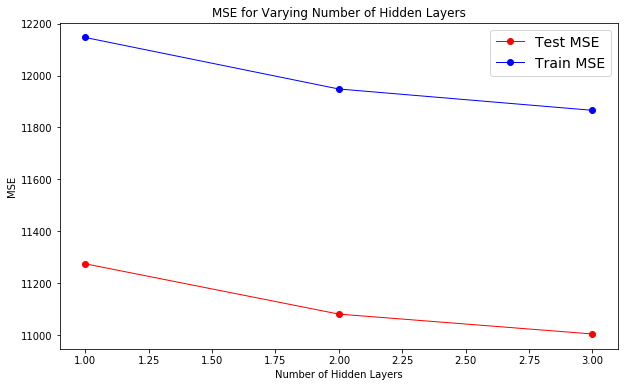

In [87]:
# First go through different numbers of hidden layers, with above conditions, and see if there is a gain in
# including more layers

layerList = [1,2,3]

mse_train, mse_test = [], []

for num_of_layers in layerList:
    print('Modeling data using %i hidden layers' %num_of_layers)
    
    if num_of_layers == 1:
        model = base_architecture_1hidden(num_neurons_layer1,X_train_clnd)
    if num_of_layers == 2:
        model = base_architecture_2hidden(num_neurons_layer1,num_neurons_layer2,X_train_clnd)
    if num_of_layers == 3:
        model = base_architecture_3hidden(num_neurons_layer1,num_neurons_layer2,
                                          num_neurons_layer3,X_train_clnd)
    if num_of_layers == 4:
        model = base_architecture_4hidden(num_neurons_layer1,num_neurons_layer2,
                                          num_neurons_layer3,num_neurons_layer4,
                                          X_train_clnd)
        
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    
    model.fit(X_train_clnd, Y_train_clnd, epochs=epoch, batch_size=batch_sizes, verbose=0)

    # Make prediction for both training and testing datasets
    Y_train_predicted = model.predict(X_train_clnd).flatten()
    Y_test_predicted = model.predict(X_test_clnd).flatten()

    # These keep track of MSE for testing and training datasets for each polynomial order considered
    mse_train.append(mean_squared_error(Y_train_clnd, Y_train_predicted))
    mse_test.append(mean_squared_error(Y_test_clnd, Y_test_predicted))

# Below plots the “mse vs. degree”
plt.figure(figsize=(10, 6))
plt.plot(layerList, mse_test, "ro-", alpha=1.0, linewidth=1.0, label="Test MSE")
plt.plot(layerList, mse_train, "bo-", alpha=1.0, linewidth=1.0, label="Train MSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Number of Hidden Layers")
plt.ylabel("MSE")
plt.title("MSE for Varying Number of Hidden Layers")
plt.show()

From the above we choose to use 2 hidden layers

In [88]:
# Choose values to examine for hyperparameter optimization
epoch_list = [10, 50, 100]
batch_sizes = [50, 100]
num_neurons_layer1_list = [100, 200, 500]
num_neurons_layer2_list = [50, 100, 200]

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [89]:
# # We now use k-fold cross-validation to find the optimal hyperparameters
# input_dims = X_train_clnd.shape[1]
# seed = 42
# kfold = KFold(n_splits=6, random_state=seed)
# cvscores=[]
# kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# model_performance_list = np.empty([1,5]) # Initialize as empty
# num_comb = len(epoch_list)*len(batch_sizes)*len(num_neurons_layer1_list)*len(num_neurons_layer2_list)
# count=1
# for epoch in epoch_list:
#     for curr_batch_size in batch_sizes:
#         for num_neurons_l1 in num_neurons_layer1_list:
#             for num_neurons_l2 in num_neurons_layer2_list:
#                 print('Looking at combination %i of %i' %(count,num_comb))
#                 count+=1

#                 model = base_architecture_2hidden(num_neurons_l1,num_neurons_l2,X_train_clnd)
#                 model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

#                 curr_score_list = []
#                 count_fold = 1
#                 for train, test in kfold.split(X_train_clnd, Y_train_clnd):

#                     count_fold += 1

#                     model.fit(X_train_clnd[train], Y_train_clnd[train],
#                                        epochs=epoch, batch_size=curr_batch_size, verbose=0)
#                     scores = model.evaluate(X_train_clnd[test], Y_train_clnd[test], verbose=0)
#                     curr_score_list.append(scores[1])
#                 curr_avg_score = np.mean(curr_score_list)

#                 model_performance_list=np.vstack((model_performance_list,
#                                               [epoch,curr_batch_size,num_neurons_l1,
#                                                num_neurons_l2,curr_avg_score]))
    
# # Remove first row from model_performance_list as it contained the random values used to initialize it
# model_performance_list=np.delete(model_performance_list, [0], axis=0)
# # Save full output of s-fold cross-validation to disk for use in report
# df_s_fold = pd.DataFrame(model_performance_list,
#                          columns=['Epoch', 'Batch Size', 'Number of Neurons-Layer1',
#                                   'Number of Neurons-Layer2','Test MSE'])
# # df_s_fold.to_csv(reposLink + '/' 'df_s_fold-batch_grad.csv')

# print('\n')
# print(df_s_fold)

# # Replace any inf or nan with np.nan for dropping in next step
# df_s_fold=df_s_fold.replace('inf', np.nan)
# df_s_fold=df_s_fold.replace('nan', np.nan)
# # Now drop all rows containing NaN
# df_s_fold=df_s_fold.dropna()
# print('\n')
# print('Below are the values corresponding to the smallest MSE from the testing sets during cross-validation')
# # Now find row index corresponding to lowest MSE from testing sets
# print(df_s_fold[df_s_fold['Test MSE']==df_s_fold['Test MSE'].min()])

Here are the optimal hyperparameters we will use:<br>

Optimal MSE = 11781.155333 <br>
epoch = 100 <br>
batch_sizes =  50 <br>
num_neurons_layer1 = 500 <br>
num_neurons_layer2 = 200 

In [90]:
epoch = 100 
batch_sizes = 50 
num_neurons_layer1 = 500 
num_neurons_layer2 = 200

In [91]:
# Now fit the model with the optimal hyperparameters
model = base_architecture_2hidden(num_neurons_layer1,num_neurons_layer2,X_train_clnd)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(X_train_clnd, Y_train_clnd, epochs=epoch, batch_size=batch_sizes, verbose=0)

In [92]:
Y_test_pred = model.predict(X_test_clnd).flatten()

print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test_clnd, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test_clnd,Y_test_pred))

The mean squared error of this prediction is 10377.728494
The r^2 value for this prediction is 0.847838


In [93]:
# Now use this to fill in actual data in the main model and use polynomial regression
# to make a prediction on the actual target (taxvaluedollarcnt)

# Create dataframe with all rows not missing any values for imputation target
data_present_df = imputational_model[pd.notnull(imputational_model['garagetotalsqft'])]

# Pull out full target Vector and full feature matrix
Y_full = imputational_model['garagetotalsqft'].values
X_full = imputational_model.drop(columns='garagetotalsqft').values

# Now create target and feature arrays for both cases
Y_present = data_present_df['garagetotalsqft'].values
X_present = data_present_df.drop(columns='garagetotalsqft').values

# Using above-found hyperparameters we fit our data, using the 
model = base_architecture_2hidden(num_neurons_layer1,num_neurons_layer2,X_present)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(X_present, Y_present, epochs=epoch, batch_size=batch_sizes, verbose=0)

# Now make a prediction for the missing values in the imputation target
Y_full_pred = model.predict(X_full)

# Now replace missing values in Y_full with their predicted values
# Y_full = [elem for elem in Y_full_pred if math.isnan(Y_full)]
for row in range(len(Y_full)):
    if math.isnan(Y_full[row]):
        Y_full[row] = Y_full_pred[row]

In [94]:
# We now make copy of the full model dataframe and drop all nan vaues from other features
drop_list = ['landtaxvaluedollarcnt','structuretaxvaluedollarcnt','finishedsquarefeet12','fullbathcnt']
df_model_ANN = df_orig[full_exp_feature_list] # Includes all features, including target
df_model_ANN.dropna(axis=0, how='any', thresh=None, subset=drop_list, inplace=True)

# We now replace the garagetotalsqft in the above dataframe with the imputed one we just calculated
df_model_ANN = df_model_ANN.drop(columns='garagetotalsqft')
df_model_ANN['garagetotalsqft'] = Y_full

nan_investigation(df_model_ANN)

,landtaxvaluedollarcnt,structuretaxvaluedollarcnt,finishedsquarefeet12,fullbathcnt,taxvaluedollarcnt,garagetotalsqft
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,73728,73728,73728,73728,73728,73728
Perc_Null,0,0,0,0,0,0


## Making Predictions On Actual Target Without Using Imputed Feature

In [95]:
# First we use the actual data without imputation, just removing missing values, to see how well that does

df_model_noImput = df_orig[full_exp_feature_list] # Includes all features, including target
# Now drop any rows missing any values
df_model_noImput.dropna(axis=0, how='any', thresh=None, inplace=True)

Y = df_model_noImput['taxvaluedollarcnt'].values
X = df_model_noImput.drop(columns=['taxvaluedollarcnt']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

With this model we now investigate the use of polynomial regression to make a prediction on the target

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3
Modeling data using degree: 4
Modeling data using degree: 5


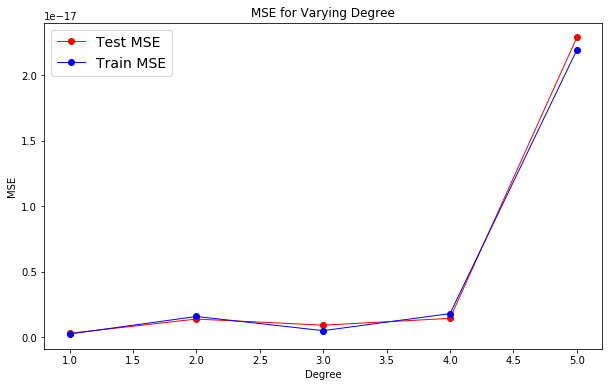

In [96]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3,4,5]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

The above looks strange, but we so no reason not to use unexpanded features.

In [97]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
# We choose 1st order
poly_degree = 1

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [98]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.001 # learning rate<br>
l1_ratio_opt = 0.5<br>
learning_rate_opt = 'constant' # (constant or updated during descent)<br>
max_iter_opt = 400<br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [99]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.001 # learning rate
l1_ratio_opt = 0.5
learning_rate_opt = 'constant' # (constant or updated during descent)
max_iter_opt = 400
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 850118992.203599
The r^2 value for this prediction is 0.996938


## Make Predictions on Target Using Imputed Values From Mean Imputation

In [100]:
# Create Feature and Target Arrays

Y = df_model_Mean['taxvaluedollarcnt'].values
X = df_model_Mean.drop(columns=['taxvaluedollarcnt']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3


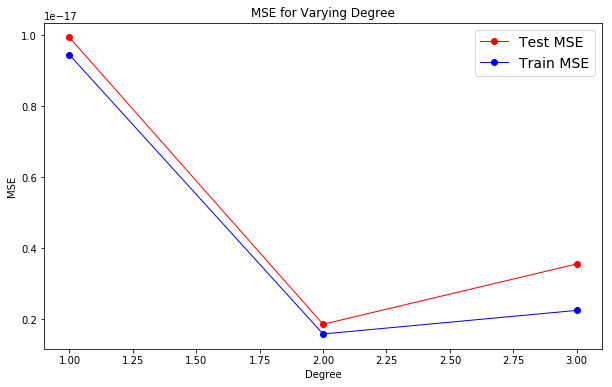

In [101]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

In [102]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
# We choose 2nd order
poly_degree = 2

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [103]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.01 # learning rate<br>
l1_ratio_opt = 0.2 <br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 10000 <br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [104]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.01 # learning rate
l1_ratio_opt = 0.2 
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 10000 
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 146041396.894963
The r^2 value for this prediction is 0.999668


## Make Predictions on Target Using Imputed Values From Expectation Maximization

In [105]:
# Create Feature and Target Arrays

Y = df_model_EM['taxvaluedollarcnt'].values
X = df_model_EM.drop(columns=['taxvaluedollarcnt']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3
Modeling data using degree: 4


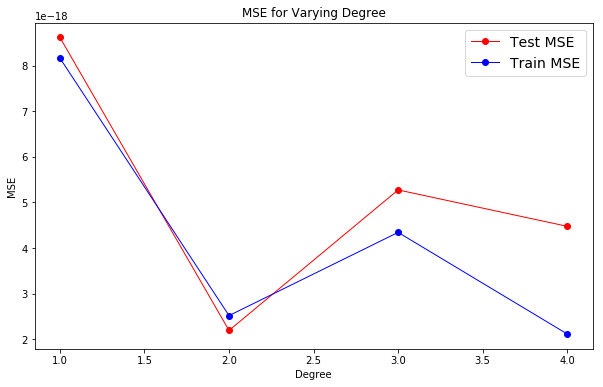

In [106]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3,4]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

The above is very strange, with Test having a lower MSE. Regardless, we will choose to use 2nd order polynomial regression and see what we get.

In [107]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
poly_degree = 2

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [108]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.001 # learning rate<br>
l1_ratio_opt = 0 <br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 10000 <br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [109]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.001 # learning rate
l1_ratio_opt = 0 
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 10000 
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 148718417.793368
The r^2 value for this prediction is 0.999662


## Make Predictions on Target Using Imputed Values From KNN Imputation

In [110]:
# Create Feature and Target Arrays

Y = df_model_KNN['taxvaluedollarcnt'].values
X = df_model_KNN.drop(columns=['taxvaluedollarcnt']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3


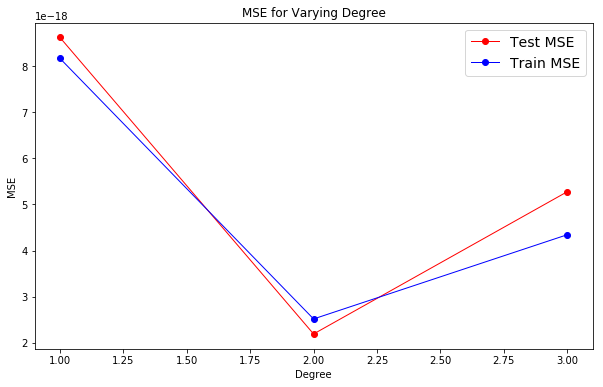

In [111]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

In [112]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
poly_degree = 2

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [113]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.1 # learning rate<br>
l1_ratio_opt = 1<br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 10000<br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [114]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.1 # learning rate
l1_ratio_opt = 1
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 10000
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 176963192.849120
The r^2 value for this prediction is 0.999597


## Make Predictions on Target Using Imputed Values From Polynomial Regression Imputation

In [115]:
# Create Feature and Target Arrays

Y = df_model_linReg['taxvaluedollarcnt'].values
X = df_model_linReg.drop(columns=['taxvaluedollarcnt']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3


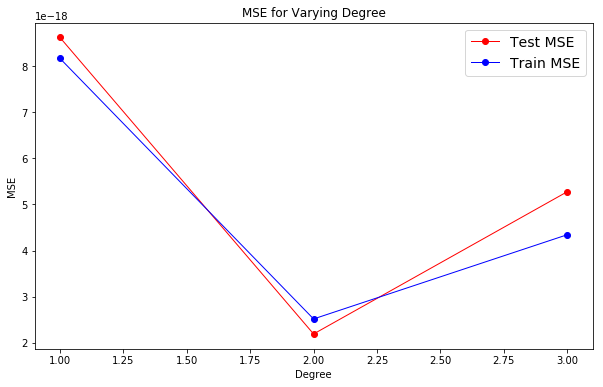

In [116]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

In [117]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
poly_degree = 2

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [118]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.001 # learning rate<br>
l1_ratio_opt = 1<br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 10000<br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [119]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.001 # learning rate
l1_ratio_opt = 1
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 10000
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 139891370.419823
The r^2 value for this prediction is 0.999682


## Make Predictions on Target Using Imputed Values From Random Forest Imputation

In [120]:
# Create Feature and Target Arrays

Y = df_model_randForest['taxvaluedollarcnt'].values
X = df_model_randForest.drop(columns=['taxvaluedollarcnt']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3


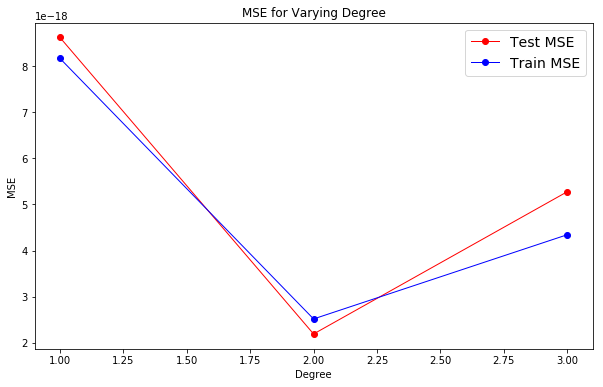

In [121]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

In [122]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
poly_degree = 2

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [123]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.01 # learning rate<br>
l1_ratio_opt = 0.5<br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 10000<br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [124]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.01 # learning rate
l1_ratio_opt = 0.5
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 10000
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 144587434.234742
The r^2 value for this prediction is 0.999671


## Make Predictions on Target Using Imputed Values From ANN Imputation

In [125]:
# Create Feature and Target Arrays

Y = df_model_ANN['taxvaluedollarcnt'].values
X = df_model_ANN.drop(columns=['taxvaluedollarcnt']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3


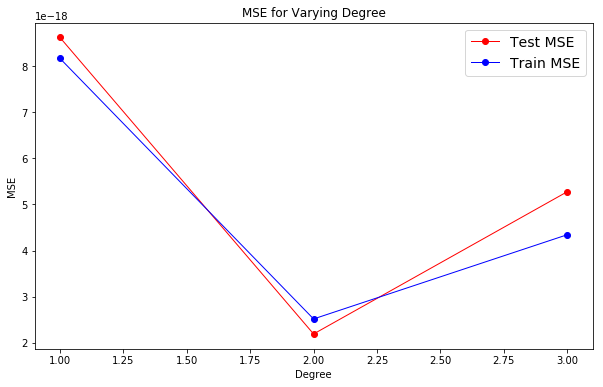

In [126]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

In [127]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
poly_degree = 2

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [128]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.01 # learning rate<br>
l1_ratio_opt = 0.5 <br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 10000 <br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [129]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.01 # learning rate
l1_ratio_opt = 0.5 
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 10000 
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 143416011.686955
The r^2 value for this prediction is 0.999674
